In [0]:
!wget 'https://raw.githubusercontent.com/cs-deep-quickdraw/notebooks/master/100_classes.txt'
!mkdir data
!pip install ndjson

--2020-02-23 13:12:27--  https://raw.githubusercontent.com/cs-deep-quickdraw/notebooks/master/100_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘100_classes.txt’

100_classes.txt     100%[===================>]     760  --.-KB/s    in 0s      

2020-02-23 13:12:27 (159 MB/s) - ‘100_classes.txt’ saved [760/760]



In [0]:
import urllib.request

f = open("100_classes.txt","r")
# And for reading use
classes = [cls.strip() for cls in f.readlines()]
f.close()

def download(classes):
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/simplified/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.ndjson'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.ndjson')

In [0]:
download(classes)

https://storage.googleapis.com/quickdraw_dataset/full/simplified/drums.ndjson
https://storage.googleapis.com/quickdraw_dataset/full/simplified/sun.ndjson
https://storage.googleapis.com/quickdraw_dataset/full/simplified/laptop.ndjson
https://storage.googleapis.com/quickdraw_dataset/full/simplified/anvil.ndjson
https://storage.googleapis.com/quickdraw_dataset/full/simplified/baseball%20bat.ndjson
https://storage.googleapis.com/quickdraw_dataset/full/simplified/ladder.ndjson
https://storage.googleapis.com/quickdraw_dataset/full/simplified/eyeglasses.ndjson
https://storage.googleapis.com/quickdraw_dataset/full/simplified/grapes.ndjson
https://storage.googleapis.com/quickdraw_dataset/full/simplified/book.ndjson
https://storage.googleapis.com/quickdraw_dataset/full/simplified/dumbbell.ndjson
https://storage.googleapis.com/quickdraw_dataset/full/simplified/traffic%20light.ndjson
https://storage.googleapis.com/quickdraw_dataset/full/simplified/wristwatch.ndjson
https://storage.googleapis.com/q

In [0]:
ls data/

airplane.ndjson      drums.ndjson       power_outlet.ndjson
alarm_clock.ndjson   dumbbell.ndjson    radio.ndjson
anvil.ndjson         envelope.ndjson    rainbow.ndjson
apple.ndjson         eyeglasses.ndjson  rifle.ndjson
axe.ndjson           eye.ndjson         saw.ndjson
baseball_bat.ndjson  face.ndjson        scissors.ndjson
baseball.ndjson      fan.ndjson         screwdriver.ndjson
basketball.ndjson    flower.ndjson      shorts.ndjson
beard.ndjson         frying_pan.ndjson  shovel.ndjson
bed.ndjson           grapes.ndjson      smiley_face.ndjson
bench.ndjson         hammer.ndjson      snake.ndjson
bicycle.ndjson       hat.ndjson         sock.ndjson
bird.ndjson          headphones.ndjson  spider.ndjson
book.ndjson          helmet.ndjson      spoon.ndjson
bread.ndjson         hot_dog.ndjson     square.ndjson
bridge.ndjson        ice_cream.ndjson   star.ndjson
broom.ndjson         key.ndjson         stop_sign.ndjson
butterfly.ndjson     knife.ndjson       suitcase.ndjson
camera.ndjson  

Test class: drums


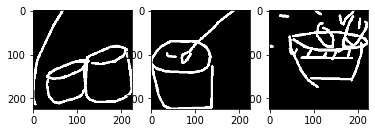

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import ndjson
import cv2

BASE_SIZE = 256
size = 224

def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def df_to_image_array_xd(df, size, lw=6, time_color=False):
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(img["drawing"] for img in df):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    return x



# Display one image
with open(f'data/{classes[0]}.ndjson') as f:
  test_cls = df_to_image_array_xd(ndjson.load(f)[:3], size)
print(f"Test class: {classes[0]}")

f, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(test_cls[0].reshape(size, size), cmap='gray')
ax2.imshow(test_cls[1].reshape(size, size), cmap='gray')
ax3.imshow(test_cls[2].reshape(size, size), cmap='gray')

In [0]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class DrawDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        assert len(self.X) == len(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return [torch.Tensor(self.X[idx]).type('torch.FloatTensor'), self.Y[idx]]

def load_dataset(max_classes=4, max_images_per_class=500):
  X = None
  Y = []

  for i, cls in enumerate(classes[:max_classes]):
    with open(f'data/{cls}.ndjson') as f:
      data = df_to_image_array_xd(ndjson.load(f)[:max_images_per_class], size).reshape(max_images_per_class, 1, size, size)
    if X is not None:
      X = np.concatenate((X, data))
    else:
      X = data

    Y.extend([i for _ in range(max_images_per_class)])

  return DrawDataset(X, Y)

In [0]:
dataset = load_dataset()
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), int(0.2*len(dataset))])

In [0]:
# we use GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [0]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(
                 dataset=train_dataset,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                 dataset=test_dataset,
                 batch_size=batch_size,
                 shuffle=True)

In [0]:
NUM_CONV_1=10 # try 32
NUM_CONV_2=20 # try 64
NUM_FC=500 # try 1024

NUM_CLASSES = 4

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv_1 = nn.Conv2d(1,NUM_CONV_1,5,1) # kernel_size = 5
        self.conv_2 = nn.Conv2d(NUM_CONV_1,NUM_CONV_2,5,1) # kernel_size = 5
        self.drop = nn.Dropout2d()
        self.fc_1 = nn.Linear(53*53*NUM_CONV_2, NUM_FC)
        self.fc_2 = nn.Linear(NUM_FC,NUM_CLASSES)
    def forward(self,x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2,2)
        x = F.relu(self.conv_2(x))
        # x = F.relu(self.drop(self.conv_2(x)))
        x = F.max_pool2d(x, 2,2)
        x = x.view(-1,53*53*NUM_CONV_2)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x
        # en utilisant loss = F.nll_loss(output, target) on peut faire
        # return F.log_softmax(x, dim=1)


In [0]:
model = CNNNet()

model.to(device) # puts model on GPU / CPU

# optimization hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) # try lr=0.01, momentum=0.9
loss_fn = nn.CrossEntropyLoss()

In [0]:
# main loop (train+test)
for epoch in range(50):
    # training
    model.train() # mode "train" agit sur "dropout" ou "batchnorm"
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = Variable(x).to(device), Variable(target).to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))

epoch 0 batch 0 [0/1600] training loss: 4.21563196182251
epoch 0 batch 100 [1000/1600] training loss: 1.370755910873413
Accuracy: 155/400 (tx 38.75%, err 61.25%)

epoch 1 batch 0 [0/1600] training loss: 1.2782886028289795
epoch 1 batch 100 [1000/1600] training loss: 1.1671233177185059
Accuracy: 239/400 (tx 59.75%, err 40.25%)

epoch 2 batch 0 [0/1600] training loss: 1.2528998851776123
epoch 2 batch 100 [1000/1600] training loss: 0.9605146646499634
Accuracy: 296/400 (tx 74.00%, err 26.00%)

epoch 3 batch 0 [0/1600] training loss: 0.5040445923805237
epoch 3 batch 100 [1000/1600] training loss: 0.6113935708999634
Accuracy: 316/400 (tx 79.00%, err 21.00%)

epoch 4 batch 0 [0/1600] training loss: 0.26300048828125
epoch 4 batch 100 [1000/1600] training loss: 0.4122363030910492
Accuracy: 317/400 (tx 79.25%, err 20.75%)

epoch 5 batch 0 [0/1600] training loss: 0.15310008823871613
epoch 5 batch 100 [1000/1600] training loss: 0.07280629873275757
Accuracy: 305/400 (tx 76.25%, err 23.75%)

epoch 6